# Classification Predict Student Solution

© Explore Data Science Academy

---
### Honour Code

I {**YOUR NAME, YOUR SURNAME**}, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

### Predict Overview: Twitter Sentiment Classification Challenge

The task involves developing a Machine Learning model to classify tweets based on people's beliefs regarding climate change. The dataset provided contains 43,943 tweets collected between April 27, 2015, and February 21, 2018. Each tweet is labeled with one of four classes: News, Pro, Neutral, or Anti, representing different perspectives on climate change.
Your company has been awarded the contract to:

 1. Analyse the supplied data;
 2. Clean and transform data, including removing noise, handling missing values, and applying text preprocessing techniques like tokenization, stop-word removal, and stemming or lemmatization;
 3. Extract relevant features from the tweet data that can contribute to the classification task;
 4. Choose an appropriate Machine Learning algorithm for the classification task;
 5. Train the model and evaluate using appropriate evaluation metrics such as accuracy, precision, recall, and F1 score;
 6. Deploy to classify new, unseen tweets into the belief classes, and
 7. Explain the inner working of the model to a non-technical audience.

Formally the problem statement was given to you, the senior data scientist, by your manager via email reads as follow:

> In this project you are tasked to model this classification problem, by exploring and preprocessing the data, perform feature engineering, and train a suitable Machine Learning model. The model will learn from the labeled tweets to classify new, unseen tweets into one of the belief classes accurately. The goal is to create a robust and accurate model that can provide valuable insights into people's perceptions of climate change.
 
On top of this, she has provided you with a starter notebook containing vague explanations of what the main outcomes are. 

<a id="cont"></a>

## Table of Contents
<a href=#one>1. Introduction</a>

<a href=#two>2. Problem Statement</a>

<a href=#three>3. Hypothesis</a>

<a href=#four>4. Importing Packages</a>

<a href=#five>5. Loading Data</a>

<a href=#six>6. Exploratory Data Analysis (EDA)</a>

<a href=#seven>7. Data Engineering</a>

<a href=#eight>8. Modeling</a>

<a href=#nine>9. Model Performance</a>

<a href=#ten>10. Model Explanations</a>

<a href=#eleven>11. Conclusion</a>

<a href=#twelve>12. References</a>

 <a id="one"></a>
## 1. Introduction
<a href=#cont>Back to Table of Contents</a>

In today's world, climate change is a pressing global issue that has gained significant attention. Many companies are dedicated to reducing environmental impact and carbon footprints by offering sustainable and environmentally friendly products and services. To gauge public sentiment and understand how their offerings may be received, these companies require insights into people's beliefs regarding climate change.


 <a id="two"></a>
## 2. Problem Statement
<a href=#cont>Back to Table of Contents</a>

Develop a Machine Learning model to classify tweets based on people's beliefs regarding climate change. The dataset includes 43,943 tweets collected between April 27, 2015, and February 21, 2018, labeled with four classes:

- News: The tweet links to factual news about climate change.
- Pro: The tweet supports the belief of man-made climate change.
- Neutral: The tweet neither supports nor refutes the belief of man-made climate change.
- Anti: The tweet does not believe in man-made climate change.

The objective is to create an accurate and robust model that can provide insights into public sentiment on climate change, aiding companies in understanding the reception of their environmentally friendly products and services for informed marketing strategies.

<a id="three"></a>
## 3. Hypothesis
<a href=#cont>Back to Table of Contents</a>

The hypothesis for the classification task of determining whether a person believes in climate change based on their tweet data is as follows:

1. Null Hypothesis (H0): There is no significant relationship between the content of a person's tweet and their belief in climate change.

2. Alternate Hypothesis (HA): The content of a person's tweet is significantly related to their belief in climate change.

Based on this hypothesis, we aim to analyze the tweet data and classify whether a person believes in climate change or not.

 <a id="four"></a>
## 4. Importing Packages
<a href=#cont>Back to Table of Contents</a>

Importing commonly used packages for data analysis and machine learning tasks in python. Packages contain pre-defined functions, classes, and other resources that can be used to perform specific tasks without having to write the code from scratch.

---
    
| ⚡ Description: Importing Packages ⚡ |
| :--------------------------- |
| In this section you are required to import, and briefly discuss, the libraries that will be used throughout your analysis and modelling. |

---

In [3]:
# Libraries for data loading, data manipulation and data visulisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from collections import Counter
from wordcloud import WordCloud
import re
import time

#Libraries for Natural Language processing
import nltk
from nltk import TreebankWordTokenizer, SnowballStemmer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string
import urllib

#Libraries for vectorising
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#Library for feature selection and resampling
from sklearn.feature_selection import VarianceThreshold
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

#Libraries for model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
#Libraries for models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB


#Libraries for measuring metrics
from sklearn.metrics import accuracy_score
from  sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#making sure that we can see all rows and cols
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [4]:
#Donwloading the stopwords, puntuations and wordnet
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

<a id="five"></a>
## 5. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In this section, data is loaded as a csv file. By loading the data, we can use the libraries to explore data, preprocess, analyze, model and gain insights.

---
    
| ⚡ Description: Loading the data ⚡ |
| :--------------------------- |
| In this section you are required to load the data from the `train` file into a DataFrame. |

---

In [2]:
# load the data
train = pd.read_csv('../resources/data/train.csv')
test = pd.read_csv('../resources/data/test_with_no_labels.csv')

<a id="six"></a>
## 6. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In this section, we will analyze the patterns and meaningfull information to better understand the dataset. EDA in classification involves removing stopwords, punctuations or any character that is not necessary before building the model.

---
    
| ⚡ Description: Exploratory data analysis ⚡ |
| :--------------------------- |
| In this section, you are required to perform an in-depth analysis of all the variables in the DataFrame. |

---


In [55]:
# checking the shape of the Training data
print(train.shape)
# Checking the shape of the Testing data
print(test.shape)

(15819, 3)
(10546, 2)


In [81]:
# Viewing the first 5 rows of training data
train.head()


,sentiment,tweetid,num_sentences,num_words,num_characters,updated message
0,1,625221,2,27,140,polyscimajor epa chief think carbon dioxide ma...
1,1,126103,1,11,62,like lack evidence anthropogenic global warming
2,2,698562,1,27,140,rt rawstory researchers say three years act cl...
3,1,573736,1,19,99,todayinmaker wired 2016 pivotal year war clim...
4,1,466954,2,26,122,rt soynoviodetodas 2016 racist sexist climate ...


In [57]:
# Viewing the first 5 rows of test data
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \r\nPu...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


**DataFrame Information**

In [79]:
print('Checking for the datatypes, null values')
print('')
# Checking for the datatypes, null values
print(train.info())

print('')
print("Checking the sum of null values")
print('')
#Checking the sum of null values
print(train.isnull().sum())

Checking for the datatypes, null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sentiment        15819 non-null  int64 
 1   tweetid          15819 non-null  int64 
 2   num_sentences    15819 non-null  int64 
 3   num_words        15819 non-null  int64 
 4   num_characters   15819 non-null  int64 
 5   updated message  15819 non-null  object
dtypes: int64(5), object(1)
memory usage: 741.6+ KB
None

#Checking the sum of null values

sentiment          0
tweetid            0
num_sentences      0
num_words          0
num_characters     0
updated message    0
dtype: int64


## Observations:

- By checking the infomation of the train set, it is confirmed that there are 15819 rows and 3 columns.
- It is also observed that there are no null values present in all the columns.
- Columns sentiment and tweetid contain numerical values, their dtype is int64. The message column contains non-numerical values, therefore it had a dtype object.
- Moreover, the dataframe takes up the space of 721.6 kb. 

**Function of separating sentiments**

In [5]:
def seperate_sent(sent_list):
    """
    This function counts the number of observations for each sentiment.

    Args:
        sent_list (list): The list of sentiments to be processed.

    Returns:
        dict: A dictionary with sentiments as keys and their corresponding counts as values.
    """
    sentiments_dict = {}  # Initialize an empty dictionary to store sentiment counts
    for num in sent_list:
        if num in sentiments_dict:  # If sentiment already exists in the dictionary
            sentiments_dict[num] += 1  # Increment the count for that sentiment
        else:
            sentiments_dict[num] = 1  # Add the sentiment to the dictionary with count 1
    return sentiments_dict

# Calling the seperate_sent function on the 'sentiment' column of the 'train' DataFrame
seperate_sent(train['sentiment'])

{1: 8530, 2: 3640, 0: 2353, -1: 1296}

**Distribution of the Tweets over Four Sentiments**

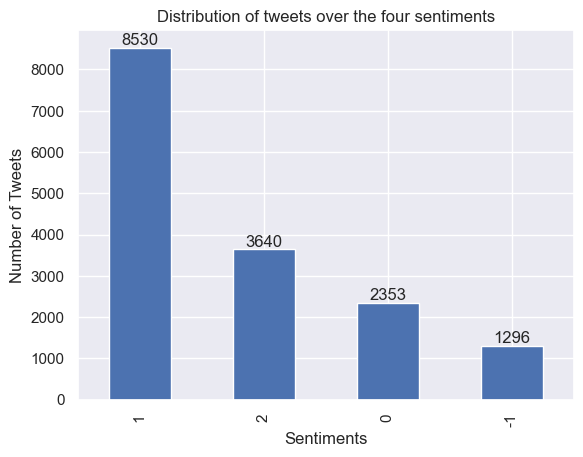

In [6]:
# Counting Number of words
train['sentiment'].value_counts().plot(kind='bar') # Plotting a bar chart of sentiment value counts in the 'train' dataset

# Getting separate lists of sentiments and their corresponding counts
sentiments = list(seperate_sent(train['sentiment']).keys()) # Extracting the unique sentiments from the 'train' dataset
numbers = list(seperate_sent(train['sentiment']).values()) # Extracting the counts of each sentiment from the 'train' dataset

# Looping over the numbers list to annotate the bar chart with the count values
for i, value in enumerate(numbers):
    plt.text(i, value, str(value), ha='center', va='bottom') # Adding a text annotation on top of each bar with the corresponding count

# Labeling the x-axis, y-axis, and the title of the plot
plt.xlabel('Sentiments')
plt.ylabel('Number of Tweets')
plt.title('Distribution of tweets over the four sentiments')

# Displaying the plot
plt.show()

## Observations:

1. The dataset contains 8530 tweets supporting man-made climate change, 3640 tweets expressing sentiment 2, 2353 tweets with neutral sentiment (sentiment 0), and 1296 tweets against man-made climate change (sentiment -1).
2. There is a significant data imbalance, with tweets supporting man-made climate change comprising more than half of the dataset.
3. The abundance of tweets supporting man-made climate change suggests that those who believe in it are well-informed and actively share their views, indicating a higher interest in the topic.
4. Conversely, those who oppose man-made climate change may be skeptical due to personal beliefs, leading to a reluctance to engage in discussions about the topic. They may also lack sufficient information to support their stance.

**Distribution of the number of characters on each tweets for the four sentiments**

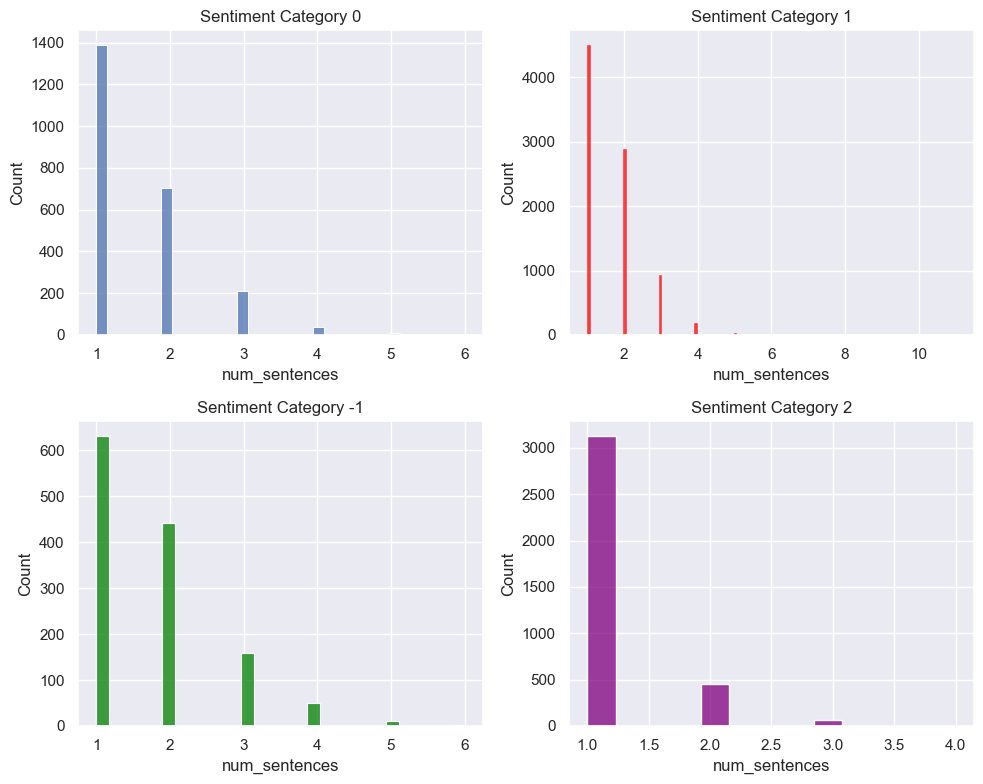

In [62]:
#Create a number of Sentences features
train['num_sentences'] = train['message'].apply(lambda x:len(nltk.sent_tokenize(x)))

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot histogram for sentiment category 0
sns.histplot(train[train['sentiment'] == 0]['num_sentences'], ax=axes[0, 0])

# Plot histogram for sentiment category 1 (with a different color)
sns.histplot(train[train['sentiment'] == 1]['num_sentences'], color='red', ax=axes[0, 1])

# Plot histogram for sentiment category -1 (with a different color)
sns.histplot(train[train['sentiment'] == -1]['num_sentences'], color='green', ax=axes[1, 0])

# Plot histogram for sentiment category -2 (with a different color)
sns.histplot(train[train['sentiment'] == 2]['num_sentences'], color='purple', ax=axes[1, 1])

# Set the title for each subplot
axes[0, 0].set_title('Sentiment Category 0')
axes[0, 1].set_title('Sentiment Category 1')
axes[1, 0].set_title('Sentiment Category -1')
axes[1, 1].set_title('Sentiment Category 2')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()

## Observations:

1. The news articles in the dataset vary in length, with a range of 1 to 4 sentences. However, tweets expressing neutral sentiment and those against man-made climate change have a slightly wider range of 1 to 6 sentences.
2. Interestingly, tweets supporting man-made climate change have the widest range of 1 to 11 sentences, indicating that some individuals who support the matter provide more extensive responses.
3. These outliers among the supporters may possess a deeper understanding of the topic due to personal experiences, research, or education.
4. Their higher level of knowledge and confidence in their stance could contribute to more detailed and well-articulated responses compared to those expressing neutral sentiment or opposing man-made climate change.

**Distribution of the Number of Words on each tweets**

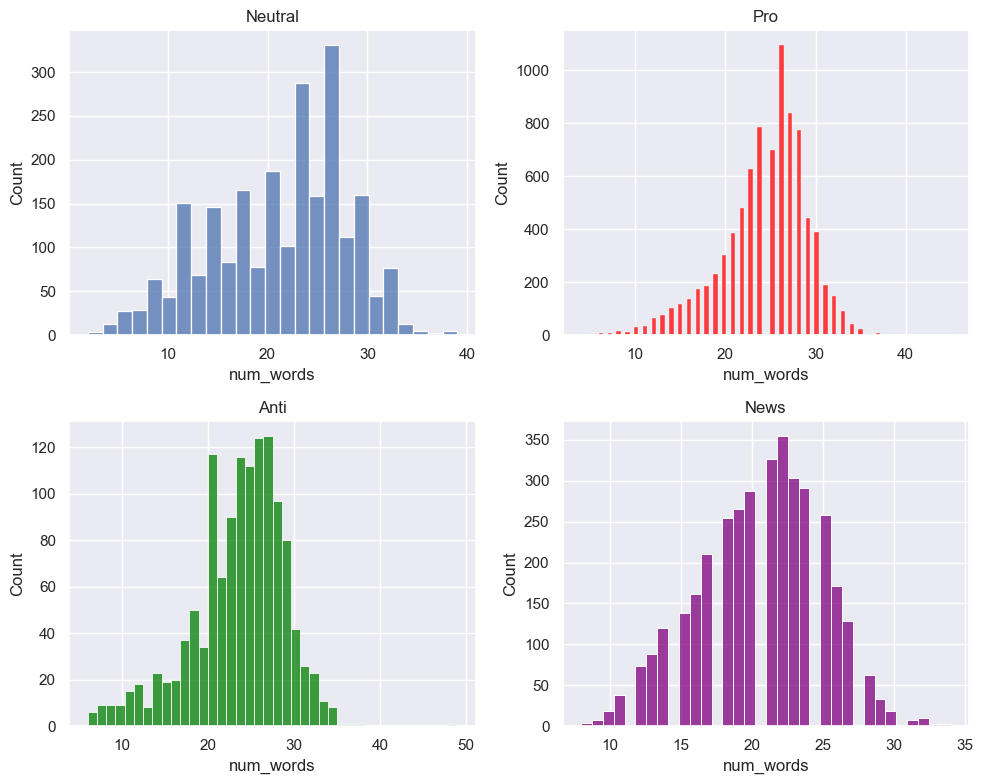

In [7]:
#Creating a number of Words feature
train['num_words'] =train['message'].apply(lambda x:len(nltk.word_tokenize(x)))

# A2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Histogram for sentiment category 0
sns.histplot(train[train['sentiment'] == 0]['num_words'], ax=axes[0, 0])

# Histogram for sentiment category 1 (with a different color)
sns.histplot(train[train['sentiment'] == 1]['num_words'], color='red', ax=axes[0, 1])

#Histogram for sentiment category -1 (with a different color)
sns.histplot(train[train['sentiment'] == -1]['num_words'], color='green', ax=axes[1, 0])

#Histogram for sentiment category 2 (with a different color)
sns.histplot(train[train['sentiment'] == 2]['num_words'], color='purple', ax=axes[1, 1])

#Titles for each subplot
axes[0, 0].set_title('Neutral')
axes[0, 1].set_title('Pro')
axes[1, 0].set_title('Anti')
axes[1, 1].set_title('News')

# Adjusting the spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()

## Observations:

1. Supporters and opponents of climate change exhibit a wider range of word count compared to tweets with neutral and news sentiments. This wider range can be attributed to the strong emotions and beliefs associated to the topic.
2. The use of more words can be seen as a response to the challenges and controversies surrounding the topic, as supporters and opponents strive to make their arguments more convincing and address potential skepticism.

**Distribution of the Number of Characters on each tweets**

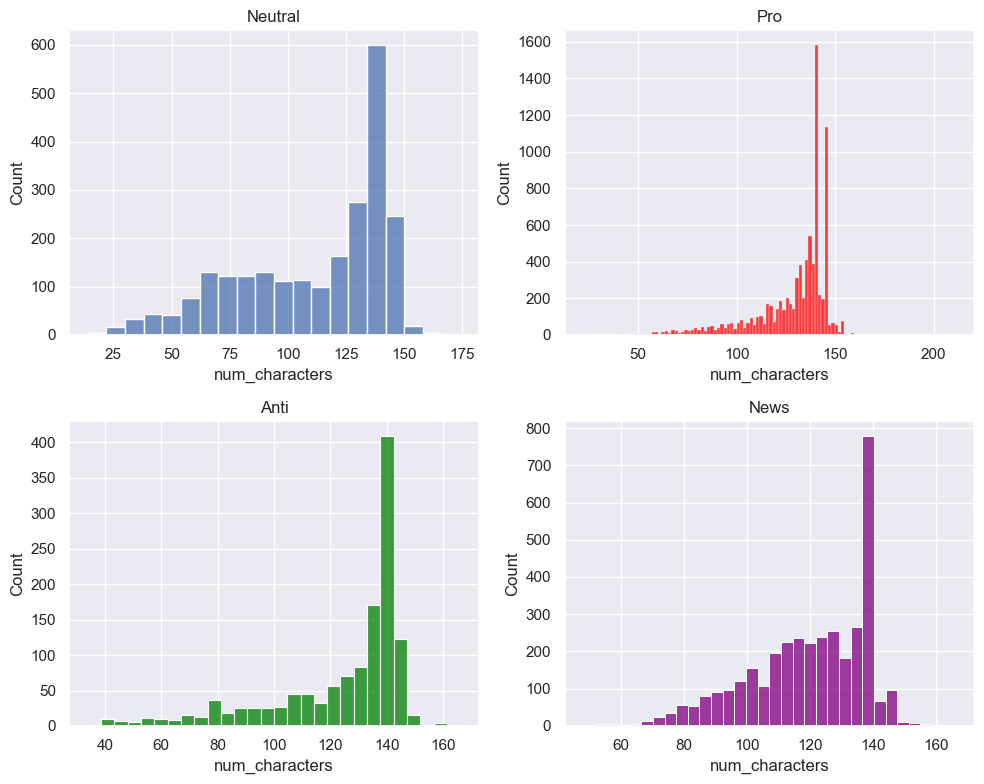

In [8]:
#Creating a number of characters feature
train['num_characters'] = train['message'].apply(len)

#A 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

#Histogram for sentiment category 0
sns.histplot(train[train['sentiment'] == 0]['num_characters'], ax=axes[0, 0])

#Histogram for sentiment category 1 (with a different color)
sns.histplot(train[train['sentiment'] == 1]['num_characters'], color='red', ax=axes[0, 1])

#Histogram for sentiment category -1 (with a different color)
sns.histplot(train[train['sentiment'] == -1]['num_characters'], color='green', ax=axes[1, 0])

#Histogram for sentiment category 2 (with a different color)
sns.histplot(train[train['sentiment'] == 2]['num_characters'], color='purple', ax=axes[1, 1])

#The title for each subplot
axes[0, 0].set_title('Neutral')
axes[0, 1].set_title('Pro')
axes[1, 0].set_title('Anti')
axes[1, 1].set_title('News')

# Adjusting the spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()

## Observations:

1. The mode of 140 characters for all sentiment categories suggests that initially, Twitter had a strict character limit of 140 per tweet. This limitation forced users to be concise and choose their words carefully to fit within the character limit.
2. However, the constraints was later increased to 280, this has enabled some individuals to fit their thoughts since the graphs above show no indication of a tweet with more than 280 characters.

**Removing Stopwords**

In [9]:
#A function of removing stopwords
def remove_stopwords(text):
    """
    Remove stopwords from the given text.

    Args:
        text (str): The input text from which stopwords are to be removed.

    Returns:
        str: The text with stopwords removed.
    """
    stop_words = set(stopwords.words('english'))  # Set of stopwords in English
    tokens = text.split()  # Splitting the text into individual words
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]  # Filtering out stopwords
    return ' '.join(filtered_tokens)  # Joining the filtered tokens back into a text
#Removing stop words from training data
train['updated_message'] = train['message'].apply(remove_stopwords)
#Viewing the changes on the training dataframe
train.head()

,sentiment,message,tweetid,num_words,num_characters,updated_message
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221,27,140,"PolySciMajor EPA chief think carbon dioxide main cause global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable"
1,1,It's not like we lack evidence of anthropogenic global warming,126103,11,62,like lack evidence anthropogenic global warming
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562,27,140,RT @RawStory: Researchers say three years act climate change it’s late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736,19,99,#TodayinMaker# WIRED : 2016 pivotal year war climate change https://t.co/44wOTxTLcD
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954,26,122,"RT @SoyNovioDeTodas: 2016, racist, sexist, climate change denying bigot leading polls. #ElectionNight"


**Removing punctuation Marks**

In [10]:
#A function of removing puntuationa marks
def remove_punctuation(post):
    """
    Remove punctuation marks from the given post.

    Args:
        post (str): The input post from which punctuation marks are to be removed.

    Returns:
        str: The post with punctuation marks removed.
    """
    return ''.join([l for l in post if l not in string.punctuation])

# Create and Check if a new column contains messages with no punctuations
train['updated_message'] = train['updated_message'].apply(remove_punctuation).str.lower() #Words converted to lower case
train['updated_message'].iloc[0]
#Viewing changes made on the training daraframe
train.head()

,sentiment,message,tweetid,num_words,num_characters,updated_message
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221,27,140,polyscimajor epa chief think carbon dioxide main cause global warming and wait what httpstcoyelvcefxkc via mashable
1,1,It's not like we lack evidence of anthropogenic global warming,126103,11,62,like lack evidence anthropogenic global warming
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562,27,140,rt rawstory researchers say three years act climate change it’s late httpstcowdt0kdur2f httpstcoz0anpt…
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736,19,99,todayinmaker wired 2016 pivotal year war climate change httpstco44wotxtlcd
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954,26,122,rt soynoviodetodas 2016 racist sexist climate change denying bigot leading polls electionnight


**Masking the four sentiments**

In [70]:
#Tweets of those who believe in Climate change
pro = train.loc[train['sentiment'] == 1, 'updated message']
#Tweets of those dont believe in climate change
anti = train.loc[train['sentiment'] == -1, 'updated message']
#Tweets of those are neautral about climate change
neutral = train.loc[train['sentiment'] == 0, 'updated message']
##Tweets of the news
news = train.loc[train['sentiment'] == 2, 'updated message']

**Word Clouds of the top fifty Words that appear the most from each sentiment**

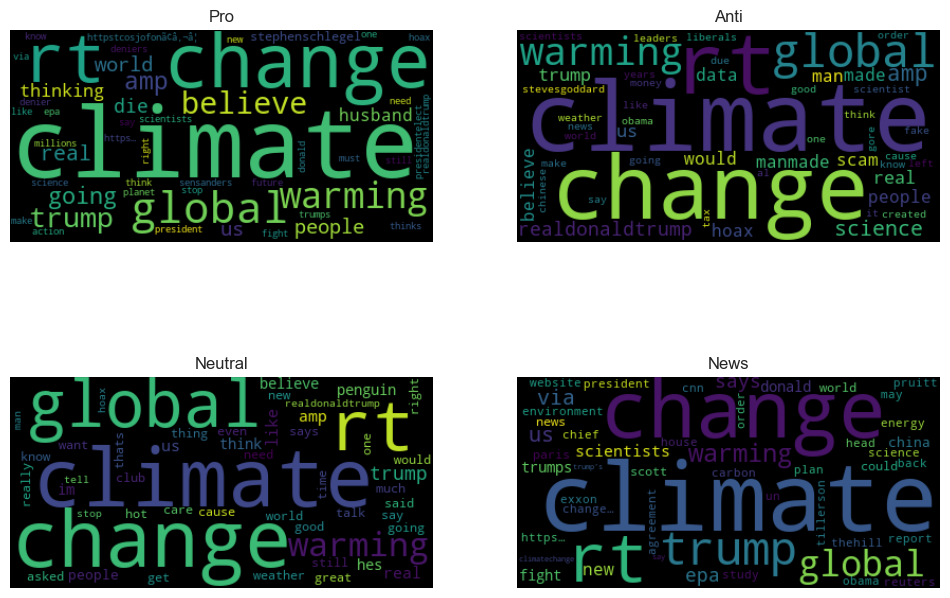

In [71]:
# Define the categories and their respective texts
categories = ['Pro', 'Anti', 'Neutral', 'News']
texts = [pro, anti, neutral, news]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
fig.subplots_adjust(hspace=0)  # Adjust the hspace parameter to remove vertical spacing

# Generate word clouds for each category and plot them
for i, ax in enumerate(axs.flat):
    # Calculate word distribution
    text = ' '.join(texts[i])
    words = text.split()
    word_counts = Counter(words)
    
    # Generate word cloud
    wordcloud = WordCloud(max_words=50)
    wordcloud.generate_from_frequencies(word_counts)
    
    # Plot the word cloud
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(categories[i])

# Show the subplots
plt.show()

## Observations:

1. Popular words: From the cloud words above, it is observed that **climate, change, global and warming** are the most popular words that are used by individuals, this is expected since the topic revolves around these words.
2. Those who support the matter use the word believe more than those who don't against the matter. Also, they use the word going and die which doesn't appear on the word cloud of those against climate change. These words may reflect concerns about the potential consequences of climate change and a sense of urgency in addressing the issue.
3. People who oppose the man-made climate change use words like **fake** and **scam** to show their resistance in the man made climate change. Moreover, they use **hoax** compared to supporters. These words suggest skepticism and validity of man-made climate change claims.

<a id="seven"></a>
## 7. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
In this section we will prepare and transform data in a suetable format for analysis and model training. Vectorization will be used and featured will be selected before training.

---

In [ ]:
#Making a copy of the training data and dropping the columns
df = train.drop(['num_sentences', 'num_words', 'num_characters'], axis=1, inplace=True)
#Making the copy of the testing data
dft = test.copy()

#Viewing the head of the training data
df.head()

**A function of removing mentions**

In [ ]:
def remove_mentions(input_text, pattern):
    '''
    This function serves to remove any mentions denoted by
    the @ symbol, followed by the Twitter handle.
    '''
    r_find = re.findall(pattern, input_text)  # Find all occurrences of mentions using the provided pattern
    for word in r_find:  # Iterate over the found mentions
        input_text = re.sub(word, '', input_text)  # Replace each mention with an empty string in the input text
    return input_text

#Applying the function on the Training data
df['cleaned_message'] = np.vectorize(remove_mentions)(df['message'],'@[\w]*')
#Applying the function on the Training data
dft['cleaned_message'] = np.vectorize(remove_mentions)(dft['message'],'@[\w]*')
#Viewing the changedmade
df.head(3)


**Replacing urls and emails**

In [ ]:
# Preprocessing function
def preprocess_text(text):
    """
    Preprocesses the given text by converting it to lowercase, replacing URLs and email addresses with placeholders,
    and removing punctuation.

    Args:
        text (str): The input text.

    Returns:
        str: The preprocessed text.
    """

    # Convert text to lowercase
    text = text.lower()

    # Define the patterns for detecting URLs and email addresses
    pattern_url = r'http\S+'
    pattern_email = r'\S+@\S+'

    # Replace URLs and email addresses with placeholders
    subs_url = 'url-web'
    subs_email = 'email-address'
    text = re.sub(pattern_url, subs_url, text)
    text = re.sub(pattern_email, subs_email, text)

    # Remove web-urls
    text = re.sub(pattern_url, subs_url, text)

    # Return preprocessed text as a string
    return remove_punctuation(text)

#Applying the function on the Training data
df['cleaned_message'] = df['cleaned_message'].apply(preprocess_text)
#Applying the function on the Testing data
dft['cleaned_message'] = dft['cleaned_message'].apply(preprocess_text)
#Viewing the changedmade
df.head(3)

**Removing Stopwords**

In [ ]:
# Define the function that remove stopwords.
def remove_stopwords(text):
    """
    Remove stopwords from the given text.

    Args:
        text (str): The input text from which stopwords are to be removed.

    Returns:
        str: The text with stopwords removed.
    """
    tokens = word_tokenize(text)  # Tokenize the input text into individual words
    filtered_tokens = [word for word in tokens if word.lower() not in stopwords.words('english')]  # Filter out stopwords from the tokens
    filtered_text = ' '.join(filtered_tokens)  # Join the filtered tokens back into a single text
    return filtered_text

#Applying the funtion to the training data
df['cleaned_message'] = df['cleaned_message'].apply(remove_stopwords)
#Applying the funtion to the testing data
dft['cleaned_message'] = dft['cleaned_message'].apply(remove_stopwords)
#Viewing the changes made
df.head()

**Stemming**

In [ ]:
def stem_text(text):
    """
    This function performs tokenization and stemming on the given text.

    Args:
        text (str): The input text to be processed.

    Returns:
        str: The processed text after stemming.
    """

    # Initialize the stemmer
    stemmer = PorterStemmer()

    # Tokenize the text
    tokens = word_tokenize(text)

    # Perform stemming on each token
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    # Join the stemmed tokens back into a string
    processed_text = ' '.join(stemmed_tokens)

    return processed_text


#Applying the funtion to the training data
df['cleaned_message'] = df['cleaned_message'].apply(stem_text)
#Applying the funtion to the testing data
dft['cleaned_message'] = dft['cleaned_message'].apply(stem_text)
#Viewing the changes made
df.head()

**Vectorization**

In [ ]:

# Creating an instance of TfidfVectorizer with maximum features set to 3000
tf = TfidfVectorizer(max_features=3000)

# Transforming the 'cleaned_message' column of the DataFrame into a matrix of TF-IDF features
X = tf.fit_transform(df['cleaned_message']).toarray()
# Transforming the 'cleaned_message' column of the testing dataFrame into a matrix of TF-IDF features
X_test = tf.transform(dft['cleaned_message']).toarray()

# Converting the 'sentiment' column of the DataFrame into a NumPy array
y = np.array(df['sentiment'])

**Feature Selection**

In [ ]:
# Initialize the SelectKBest feature selector with chi-squared scoring function and select 'all' features
selector = SelectKBest(score_func=chi2, k='all')
# Transform the feature matrix X to select the top k features based on chi-squared test
X_new = selector.fit_transform(X, y)
# Transform the feature matrix X of the testing to select the top k features based on chi-squared test
X_new = selector.transform(X, y)

<a id="seven"></a>
## 7. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
Models will be created to train the data. The models will be trained to learn the relationships, patterns and parameters from the input features and their target values.

---

**Spliting the data**

In [ ]:
# X_new is the transformed feature matrix and y is the target variable

# Split the data into training and testing sets
# X_train: Training feature matrix
# X_test: Testing feature matrix
# y_train: Training target variable
# y_test: Testing target variable
# test_size=0.2: 20% of the data will be used for testing, while 80% will be used for training
# random_state=42: Set the random seed to ensure reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

**Naming all the Models to be built**

In [ ]:
names = ['Logistic Regression', 'Nearest Neighbors',
         'RBF SVM',
         'Decision Tree', 'Random Forest']

**Building the model**

In [ ]:
classifiers = [
    LogisticRegression(max_iter=1000),
    KNeighborsClassifier(10),
    SVC(kernel="rbf", gamma=2, C=0.025),
    DecisionTreeClassifier(min_samples_split=2),
    RandomForestClassifier(n_estimators=100, max_depth=3)
]

**Training, predicting on the data  and model performance**

In [ ]:
results_train = []
results_test=[]

models = {}
confusion = {}
class_report = {}

for name, clf in zip(names, classifiers):

    #Fitting the models and recording the time
    run_time = %timeit -q -o clf.fit(X_train, y_train)

    #Start time
    start_time = time.time()
    #Predicting on y_train using X_train
    y_pred = clf.predict(X_train)
    #End time
    end_time = time.time()
    #Execution Time
    train_execution_time = end_time - start_time

    #Start time
    start_time = time.time()
    #Predicting on y_train using X_train
    y_pred_test = clf.predict(X_test)
    #End time
    end_time = time.time()
    #Execution Time
    test_execution_time = end_time - start_time

    #Calculating the accuracy score of the training data
    accuracy_train = accuracy_score(y_train, y_pred)
    #Calculating the precision score of the training data
    precision_train = precision_score(y_train, y_pred, average='micro')
    #Calculating the recall score of the training data
    recall_train = recall_score(y_train, y_pred, average='micro')
    #Calculating the f1 score of the training data
    f1_train = f1_score(y_train, y_pred, average='micro')


    #Calculating the accuracy score of the testing data
    accuracy_test = accuracy_score(y_test, y_pred_test)
    #Calculating the precision score of the testing data
    precision_test = precision_score(y_test, y_pred_test, average='micro')
    #Calculating the recall score of the testing data
    recall_test = recall_score(y_test, y_pred_test, average='micro')
    #Calculating the F1 score of the testing data
    f1_test   = f1_score(y_test, y_pred_test, average='micro')

    # Save the results to dictionaries
    models[name]=clf
    #Confusion on the training data
    confusion[name] = confusion_matrix(y_train, y_pred)
    #Confusion on testing data
    confusion[name] = confusion_matrix(y_test, y_pred_test)
    #Classification report of the training data
    class_report[name] = classification_report(y_train, y_pred)
    #Classification report of the testing data
    class_report[name] = classification_report(y_test, y_pred_test)

    # Appending the name of the model, training data  results and fitting time of each model
    results_train.append([name, accuracy_train, precision_train, recall_train, f1_train, run_time.best, train_execution_time])
    # Appending the name of the model and  testing data  results
    results_test.append([name, accuracy_test, precision_test, recall_test, f1_test, test_execution_time])

#Converting the training results to a dataframe
results_train= pd.DataFrame(results_train, columns=['Classifier', 'Accuracy Train', 'Precision Train', 'Recall', 'F1 Train', 'Train Time', 'predicting time'])
results_train.set_index('Classifier', inplace= True)

#Converting the Testing data into a Dataframe
results_test= pd.DataFrame(results_test, columns=['Classifier', 'Accuracy Test', 'Precision  Test', 'Recall  Test', 'F1 Test', "Predicting time" ])
results_test.set_index('Classifier', inplace= True)

<a id="eight"></a>
## 8. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
The different models will be evaluated and the perfomance will be assessed using different evaluation metrics. By eveluating the model, we can observe the best perfoming model.

---

In [ ]:
# Compare model performance

In [ ]:
# Choose best model and motivate why it is the best choice

<a id="nine"></a>
## 9. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
 In this section, we explain the best performing model and gain understanding on why it performed better.
 
---

In [ ]:
# discuss chosen methods logic

<a id="ten"></a>
## 10. Conclusion
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

<a id="eleven"></a>
## 11. References
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>